#Import

In [1]:
pip install pytorch_lightning --quiet

In [2]:
!rm -r DL_Project
!git clone https://github.com/stefanoiervese/DL_Project
%cd DL_Project
!unzip Arithmetic_extrapolate.zip -d arithmetic_extrapolate
!unzip Arithmetic_interpolate.zip -d arithmetic_interpolate
!unzip Arithmetic.zip -d arithmetic_directory

Cloning into 'DL_Project'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 114 (delta 24), reused 9 (delta 9), pack-reused 82
Receiving objects: 100% (114/114), 55.79 MiB | 42.16 MiB/s, done.
Resolving deltas: 100% (51/51), done.
/content/DL_Project
Archive:  Arithmetic_extrapolate.zip
  inflating: arithmetic_extrapolate/Arithmetic_extrapolate/arithmetic__div_big.txt  
  inflating: arithmetic_extrapolate/Arithmetic_extrapolate/arithmetic__mul_big.txt  
  inflating: arithmetic_extrapolate/Arithmetic_extrapolate/arithmetic__add_sub_multiple_longer.txt  
  inflating: arithmetic_extrapolate/Arithmetic_extrapolate/arithmetic__add_or_sub_big.txt  
Archive:  Arithmetic_interpolate.zip
  inflating: arithmetic_interpolate/Arithmetic_interpolate/arithmetic__add_sub_multiple.txt  
  inflating: arithmetic_interpolate/Arithmetic_interpolate/arithmetic__add_or_sub.txt  
  inflating: arithmetic_inte

In [3]:
import pytorch_lightning as pl
import os
import random
import re
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence


# Utilities

In [24]:
class Dataset(Dataset):
    def __init__(self, questions, answers):
        self.questions = questions
        self.answers = answers

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return self.questions[idx], self.answers[idx]

class Tokenizer:
    def __init__(self, sentences):
        self.sentences = sentences
        self.vocab = self.crea_vocabolario(sentences)
        self.word_to_id = {word: idx for idx, word in enumerate(self.vocab)}

    def tokenize(self, text):
        txt = re.sub(r'(\d+)', lambda x: ' '.join(list(x.group(1))), text)
        tokens = re.findall(r'\b\w+\b|\d+|[^\w\s]', txt)

        token_id = []
        unknown_tokens = []

        new_tokens = []
        for token in tokens:
            flag = 0
            if '.' in token and token != '.':
                token = token.split('.')[0]
                flag = 1
            if token in self.word_to_id:
                token_id.append(self.word_to_id[token])
            else:
                token_id.append(self.word_to_id['unknown'])
                unknown_tokens.append(token)
            if flag == 1:
                token_id.append(self.word_to_id['.'])

        if unknown_tokens:
            print("Parole sconosciute:", unknown_tokens)

        return token_id

    def crea_vocabolario(self, frasi):
        vocabolario = set()

        for frase in frasi:
            txt = re.sub(r'(\d+)', lambda x: ' '.join(list(x.group(1))), frase.lower())
            parole = re.findall(r'\b\w+\b|\d+|[^\w\s]', txt)
            vocabolario.update(parole)
        return ['&', '#', '@', 'unknown'] + list(vocabolario)

    def tokenize_q_and_a(self, questions, answers):
        q = []
        a = []
        for x in questions:
            q.append(torch.tensor(self.tokenize(x.lower())))
        for x in answers:
            a.append(torch.tensor(self.tokenize(x.lower())))
        return q, a


def build_dataset(data, q, a, tokenizer):
    q, a = tokenizer.tokenize_q_and_a(q, a)
    q, a = padding(q, a)
    return q, a


def load_dataset(path):
    data = []
    for file in os.listdir(path):
        with open(path + file, "r") as file:
            content = file.read()
            data = data + [x for x in content.split('\n')]
    while '' in data:
        data.remove('')
    len_data = len(data)
    questions = []
    answers = []
    for i in range(len_data):
        if(i % 2 == 0):
            questions.append(data[i])
        else:
            dt = data[i] + " @"
            answers.append(dt)
    coppie = list(zip(questions, answers))
    random.shuffle(coppie)
    questions, answers = zip(*coppie)
    return data, questions, answers


def split_dataset(questions, answers):
    l = int(len(questions) / 3)
    train_q = questions[:2 * l]
    test_q = questions[2 * l:]
    train_a = answers[:2 * l]
    test_a = answers[2 * l:]
    return train_q, train_a, test_q, test_a


def padding(questions, answers):
    max_length1 = max(len(tensor) for tensor in questions)
    max_length2 = max(len(tensor) for tensor in answers)
    max_length = max(max_length1, max_length2)
    q_padded = pad_sequence([torch.cat([tensor, torch.zeros(max_length - len(tensor), dtype=torch.int)]) for tensor in questions], batch_first=True)
    a_padded = pad_sequence([torch.cat([tensor, torch.zeros(max_length - len(tensor), dtype=torch.int)]) for tensor in answers], batch_first=True)
    return a_padded, q_padded

def paper_accuracy(predicted_answers, correct_answers):
  num_correct_answers = 0
  end_of_line=2

  for i in range(len(predicted_answers)):

    single_predicted_answer = torch.argmax(predicted_answers[i], 1).tolist()  # vector of shape (answer_max_length) (concatenates the max value for each row)
    index = single_predicted_answer.index(2) if 2 in single_predicted_answer else len(single_predicted_answer) -1
    single_predicted_answer = single_predicted_answer[0:index]  # removing start and end of line char and additional characters
    single_correct_answer = correct_answers[i].tolist()
    single_correct_answer = single_correct_answer[0:single_correct_answer.index(2)]  # removing start of line, end of line and following characters

    if (single_predicted_answer == single_correct_answer):
      num_correct_answers += 1

  return num_correct_answers/len(predicted_answers)


def translate(phrase, vocab):
    text = ""
    for element in phrase:
        text += vocab[element.item()]
    return text

def translate_from_output(phrase, vocab):
    phrase = torch.argmax(F.softmax(phrase , dim = -1), dim = -1)
    text = ""
    for element in phrase:
        text += vocab[element.item()]
    return text

def print_correct(dictionary, batch, res):

  batch_q, batch_a =batch

  for i in range(len(res)):

    index_list = torch.argmax(res[i], 1) # reverse one_hot
    predicted_string = answer_string = question_string = ""

    for j in range(len(batch_q[i])):
      question_string = question_string  + " " + dictionary[batch_q[i][j].item()]

    for j in range(len(index_list)):
      predicted_string = predicted_string + " " + dictionary[index_list[j].item()]

    for j in range(len(batch_a[i])):
      answer_string = answer_string + " " + dictionary[batch_a[i][j].item()]

    print(dictionary)

    print("QUESTION " + question_string + "\n", "PREDICTED " + predicted_string + "\n","CORRECT " + answer_string + "\n")



# Dataset preprocessing

In [26]:
path_train = './arithmetic_directory/Arithmetic/'
path_ext = './arithmetic_extrapolate/Arithmetic_extrapolate/'
path_inter = './arithmetic_interpolate/Arithmetic_interpolate/'
batch_size = 64


data, q, a = load_dataset(path_ext)
tokenizer = Tokenizer(data)
q_ext, a_ext = build_dataset(data, q, a, tokenizer)


ext_dataset = Dataset(q_ext, a_ext)
ext_loader = DataLoader(ext_dataset, batch_size=batch_size, shuffle=True)

data, q, a = load_dataset(path_train)
q_train, a_train, q_test, a_test = split_dataset(q, a)
q_train, a_train = build_dataset(data, q_train, a_train, tokenizer)
#q_test, a_test = build_dataset(data, q_test, a_test)

#ata, q, a = load_dataset(path_inter)
#q_inter, a_inter = build_dataset(data, q, a)


train_dataset = Dataset(q_train, a_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test_dataset = Dataset(q_test, a_test)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#inter_dataset = Dataset(q_inter, a_inter)
#inter_loader = DataLoader(inter_dataset, batch_size=batch_size, shuffle=True)



In [23]:
print(len(tokenizer.word_to_id))

54


# LSTM

In [6]:
from torch.nn.modules import dropout
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import random


class LSTM(pl.LightningModule):
  def __init__(self, dict_size, size, dictionary, teacher_forcing_ratio: float = 0.5):
    super().__init__()

    self.hidden_units = 2048
    self.dict_size = dict_size
    self.teacher_forcing_ratio = teacher_forcing_ratio
    self.dictionary = dictionary
    self.question_max_length=size
    self.answer_max_length=size
    # Initializing used layers
    self.lstm = nn.LSTM(self.dict_size, self.hidden_units)
    self.linear_layer = nn.Linear(self.hidden_units, dict_size, bias=False)  # used to return vectors of shape (dict_size)

  def forward(self, batch):
    batch_q, batch_a = batch

    batch_size = len(batch_q)
    batch_questions = batch_q  # shape (batch_size, question_max_length)
    batch_questions = torch.transpose(batch_questions, 0, 1)  # shape (question_max_length, batch_size)
    batch_questions = F.one_hot(batch_questions, self.dict_size)  # shape (question_max_length, batch_size, dict_size)
    batch_questions = batch_questions.float().to(device)

    if self.training:
      batch_answers = batch_a  # shape (batch_size, answer_max_length)
      batch_answers = torch.transpose(batch_answers, 0, 1)  # shape (answer_max_length, batch_size)
      batch_answers = F.one_hot(batch_answers, self.dict_size)  # shape (answer_max_length, batch_size, dict_size)
      batch_answers = batch_answers.float().to(device)

    # Initializing hidden_state and cell_state used by the lstm cell.
    hidden_state = torch.zeros(1, batch_size, self.hidden_units, requires_grad=True, dtype=torch.float).to(device)  # shape (D*num_layers, batch_size, H_out)
    cell_state = torch.zeros(1, batch_size, self.hidden_units, requires_grad=True, dtype=torch.float).to(device)  # shape (D*num_layers, batch_size, H_cell)

    # Initializing result tensor
    result = torch.empty(self.answer_max_length, batch_size, self.dict_size).to(device)  # shape (answer_max_length, batch_size, dict_size)


    # input shape (1, batch_size, dict_size)
    # output shape (1, batch_size, hidden_size)
    for i in range(self.question_max_length):
      output, (hidden_state, cell_state) = self.lstm(batch_questions[i].unsqueeze(0), (hidden_state, cell_state))


    for i in range(self.answer_max_length):

      result_temp = self.linear_layer(output[0])  # shape (batch_size, dict_size)
      result[i] = result_temp

      if self.training:
        teacher_force = random.random() < self.teacher_forcing_ratio  # true or false with prob 'teacher_forcing_ratio'

        if teacher_force:  # use correct previous char
          input = batch_answers[i].unsqueeze(0)  # shape (1, batch_size, dict_size)
        else:  # use previous predicted char
          input = F.one_hot(torch.argmax(result_temp, 1), self.dict_size).unsqueeze(0).float().to(device)  # shape (1, batch_size, dict_size)

      else:
        if i == 0:
          input = F.one_hot(torch.tensor([1]), self.dict_size).repeat(batch_size, 1).unsqueeze(0).float().to(device)  # shape (1, batch_size, dict_size)
        else:
          input = F.one_hot(torch.argmax(result_temp, 1), self.dict_size).unsqueeze(0).float().to(device)  # shape (1, batch_size, dict_size)

      output, (hidden_state, cell_state) = self.lstm(input, (hidden_state, cell_state))  # shape (1, batch_size, hidden_size)
    return torch.transpose((result), 0, 1)  # shape (batch_size, answer_max_length, dict_size)

  def training_step(self, batch, _):
    batch_q, batch_a = batch
    # Preparing inputs
    batch_answers = batch_a  # shape (batch_size, answer_max_length)
    batch_answers = batch_answers.flatten(0, 1)  # shape (batch_size * answer_max_length)

    # Computing prediction and loss

    pred = self(batch).flatten(0, 1)  # shape (batch_size * answer_max_length, dict_size)
    loss = F.cross_entropy(pred, batch_answers, ignore_index=0)
    losses.append(loss.detach().cpu().item())

    return loss

  def validation_step(self, batch, _):
    batch_q, batch_a = batch

    # Computing prediction and accuracy
    pred = self.predict(batch)  # shape (batch_size, answer_max_length, dict_size)
    accuracy = paper_accuracy(pred, batch_a)

    self.log("val_tot_accuracy", accuracy)
    return accuracy

  def test_step(self, batch, batch_idx):

    batch_q, batch_a = batch

    # Computing prediction and accuracy
    pred = self(batch)  # shape (batch_size, answer_max_length, dict_size)
    accuracy = paper_accuracy(pred, batch_a)

    print_correct(self.dictionary, batch, pred)

    print(accuracy)
    acc.append(accuracy)
    return accuracy

  def predict(self, questions):
    return self(questions)

  def print_predict(self, questions):
    pred = self.predict(questions.copy())
    return

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=6e-4, betas=(0.9, 0.995), eps=1e-9)

In [10]:
max_length1 = max(len(tensor) for tensor in qt)
max_length2 = max(len(tensor) for tensor in at)
max_length=max(max_length1,max_length2)

max_length1 = max(len(tensor) for tensor in qtest)
max_length2 = max(len(tensor) for tensor in atest)
max_length_test=max(max_length1,max_length2)

max_length=max([max_length, max_length_test])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(max_length)
acc=[]
losses=[]
net = LSTM(len(tokenizer.vocab),max_length, tokenizer.vocab)
net.to(device)
trainer= pl.Trainer(max_epochs=2)

trainer.fit(net, train_loader)

NameError: ignored

In [ ]:
del

NameError: ignored

In [ ]:
del losses

In [ ]:
model_path='./model_LSTM.pth'
torch.save(net.state_dict(), model_path)

In [ ]:
model_path='./model_LSTM.pth'
net.load_state_dict(torch.load(model_path))
net.eval()

acc = []

trainer.test(net,test_loader)

In [ ]:
sum(acc)/len(acc)

0.006392045454545455

In [ ]:
lista_losses = [tensor.item() for tensor in losses]

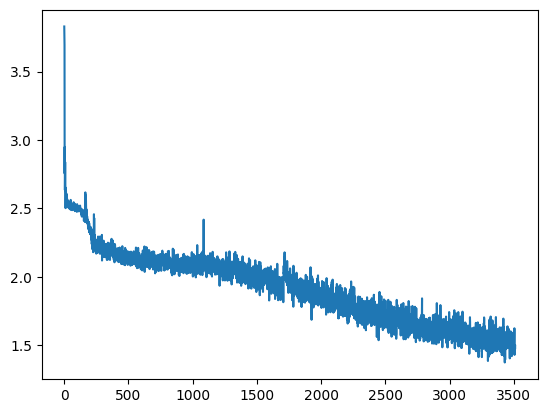

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lista_losses)
plt.show()

# Transformer

In [27]:

import torch
import torch.nn as nn
import math
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F

class MultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads,dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads

        # Inizializzazione dei moduli lineari per proiettare Q, K, V e l'output.
        self.W_q = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_k = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_v = nn.Linear(self.emb_dim, self.emb_dim)
        self.W_o = nn.Linear(self.emb_dim, self.emb_dim)


    def forward(self, q,k,v, mask=False):
        q = self.split_heads(self.W_q(q))  #64,2,22,2
        k = self.split_heads(self.W_k(k))  #64,2,2,22
        v = self.split_heads(self.W_v(v))


        att = self.att_score(q, k, v, mask)  #62,2,22,22
        out = self.W_o(self.combine_heads(att))

        return out

    def att_score(self, q, k, v, mask):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask:
          attn_scores=self.apply_mask(attn_scores)

        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, head_dim = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.emb_dim)

    def apply_mask(self,tensor):
        mask = torch.triu(torch.full((tensor.shape[2], tensor.shape[3]), float("-inf"), device= device), diagonal=1)
        tensor = tensor + mask

        return tensor


class EncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(EncoderLayer, self).__init__()

        self.multihead_attention = MultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x,x,x)

        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))


        return out





class Encoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList([
            EncoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class DecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # Self-Attention Layer (Auto-Attention)
        self.self_attention = MultiHeadAttention(emb_dim, num_heads)

        # Cross-Attention Layer (Attenzione incrociata con l'encoder)
        self.cross_attention = MultiHeadAttention(emb_dim, num_heads)

        # Feedforward Neural Network Layer
        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x, mask=True)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output, encoder_output)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(out2)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3

class Decoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(Decoder, self).__init__()


        self.layers = nn.ModuleList([
            DecoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x

class Transformer(pl.LightningModule):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8, num_layers=6, d_ff=256, dropout=0.1, teacher_forcing_ratio = 0.9):
        super(Transformer, self).__init__()
        self.d_model=d_model

        self.num_heads=num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.tgt_vocab_size=tgt_vocab_size

        self.transformer_encoder = Encoder(self.d_model,self.num_heads)
        self.transformer_decoder = Decoder(self.d_model,self.num_heads)

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)


    def forward(self, batch):

        if self.training:
            teacher_force = random.random() < self.teacher_forcing_ratio
            if teacher_force:
                return self.classic_forward(batch)
            else:
                return self.predict(batch[0])
        return self.predict(batch)

    def classic_forward(self,batch):
        src,tgt = batch
        max_seq_length=src.shape[1]
        batch_size = src.shape[0]
        tgt = torch.cat((torch.ones((batch_size,1), dtype=torch.int).to(device), tgt[:, :-1]), dim = 1)

        src_embedded = self.dropout(self.src_embedding(src))+self.positional_encoding(max_seq_length,self.d_model).to(device)
        tgt_embedded = self.dropout(self.tgt_embedding(tgt))+self.positional_encoding(max_seq_length,self.d_model).to(device)

        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)
        output = self.fc(dec_output)

        return output


    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        losses.append(loss.cpu().detach().numpy())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch
        ans_len=batch_a.shape[1]

      # Computing prediction and accuracy
        pred = self(batch_q)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)  # accuracy for the current batch as defined in the "mathematics dataset" paper

        #print(accuracy)  # at the end of every epoch it is logged the average of the accuracies of each batch
        acc.append(accuracy)

        return accuracy



    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding

    def predict(self, x):
        length=x.shape[1]
        src_embedded = self.src_embedding(x).to(device)+self.positional_encoding(length,self.d_model).to(device)
        encode = self.transformer_encoder(src_embedded)
        batch_dim = x.shape[0]
        out = torch.zeros((batch_dim, length), dtype = torch.int).to(device)
        out[:,0] = 1
        output=torch.zeros(batch_dim,length,self.tgt_vocab_size).to(device)
        for i in range(length - 2 ):
            tgt_embedded = self.tgt_embedding(out)+self.positional_encoding(length,self.d_model).to(device)
            decode = self.transformer_decoder(tgt_embedded, encode)
            output[:,i]+=self.fc(decode)[:,i]
            prob = F.softmax(output , dim = -1)
            arg_max = torch.argmax(prob, dim = -1)
            out[:, i+1] = arg_max[:,i]
        return self.classic_forward((x,out))


torch.cuda.empty_cache()
acc=[]
losses=[]
voc_len=len(tokenizer.vocab)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t=Transformer(voc_len,voc_len)
t.to(device)
print(device)
# Addestra il modello

trainer = pl.Trainer(max_epochs=1)  # Modifica il numero di epoche come desiderato
trainer.fit(t, train_loader)


#model_path='/content/drive/MyDrive/mathematics_dataset-v1.0/model'


#torch.save(t.state_dict(), model_path)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type      | Params
--------------------------------------------------
0 | src_embedding       | Embedding | 27.6 K
1 | tgt_embedding       | Embedding | 27.6 K
2 | transformer_encoder | Encoder   | 6.5 M 
3 | transformer_decoder | Decoder   | 12.8 M
4 | fc                  | Linear    | 27.7 K
5 | dro

cuda


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
sum(acc)/len(acc)

In [ ]:
print(t.device)

In [ ]:
model_path='./model.pth'
torch.save(t.state_dict(), model_path)
#trainer.test(t,test_loader)



In [43]:
acc = []
trainer.test(t,test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: ignored

In [ ]:
tokenizer.vocab[0]
type(tokenizer.vocab)
print(tokenizer.vocab)

In [ ]:
i = 1
q,a= train_dataset[i]
length = q.shape[0]
print(q.device)
print(t.device)
print(device)
t.to(device)
print(q.unsqueeze(0))
pred = t.predict(q.unsqueeze(0).to(device))
c = translate_from_output(pred.squeeze(0), tokenizer.vocab)
d = translate(a.squeeze(0), tokenizer.vocab)
print(pred)
print(translate(q,tokenizer.vocab))
print(translate(a,tokenizer.vocab))
print("trad 1: ", translate_from_output(pred.squeeze(0),tokenizer.vocab))
g = a

In [ ]:
loaded_list = []

with open('losses.pickle', 'wb') as file:
    pickle.dump(losses, file)

# Caricamento della lista da un file
with open('losses.pickle', 'rb') as file:
    loaded_list = pickle.load(file)

In [ ]:
sum(acc)/len(acc)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

In [ ]:
torch.save(t.state_dict(), 'trainato')

In [29]:
t.load_state_dict(torch.load(path))

RuntimeError: ignored

In [28]:
print(os.listdir("../"))
TPpath = "../drive/MyDrive/models/TPTransformer_3epoc_95acc.pt"
path = "../drive/MyDrive/models/transformer-3epoc-512d-acc91.pt"

['.config', 'DL_Project', 'drive', "Nico's cards.txt", 'sample_data']


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TP-Transformer

In [21]:
import torch
import torch.nn as nn
import math
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F

class TPAttentionHead(pl.LightningModule):
    def __init__(self, emb_dim, emb_head, dropout=0.0):
        super(TPAttentionHead, self).__init__()

        self.emb_dim = emb_dim
        self.emb_head = emb_head

        # Inizializzazione dei moduli lineari per proiettare Q, K, V e l'output.
        self.W_q = nn.Linear(self.emb_dim, self.emb_head)
        self.W_k = nn.Linear(self.emb_dim, self.emb_head)
        self.W_v = nn.Linear(self.emb_dim, self.emb_head)
        self.W_r = nn.Linear(self.emb_dim, self.emb_head)
        self.W_o = nn.Linear(self.emb_head, self.emb_dim)


    def forward(self, q, k, v, r, mask = False):

        q = self.W_q(q)
        k = self.W_k(k)
        v = self.W_v(v)
        r = self.W_r(r)

        att = self.att_score(q, k, v, mask = mask)  #62,2,22,22

        return self.W_o(att*r)

    def att_score(self, q, k, v, mask = False):

        attn_scores = torch.matmul(q, k.transpose(1, 2)) / math.sqrt(self.emb_head)
        if mask: attn_scores=self.apply_mask(attn_scores)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def apply_mask(self,tensor):

        mask = torch.triu(torch.full((tensor.shape[1], tensor.shape[2]), float("-inf"), device=device), diagonal=1)
        tensor = tensor + mask
        return tensor

class TPMultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads,dropout=0.0):
        super(TPMultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads

        # Layers Initialization
        self.attention_heads = nn.ModuleList([TPAttentionHead(self.emb_dim, self.head_dim) for _ in range(self.num_heads)])

    def forward(self, q, k, v, r, mask = False):  # input shape (batch_size, len_k/len_q/len_v, embedding_size)

        attention_heads_results = []

        for head in self.attention_heads:
          attention_heads_results.append(head( q, k, v, r, mask = mask))  # shape (batch_size, len_q, dv)
        concatenated_results = torch.stack(attention_heads_results)  # shape (batch_size, len_q, num_heads*dv)

        return torch.sum(concatenated_results, dim=0)

class TPEncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(TPEncoderLayer, self).__init__()

        self.multihead_attention = TPMultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x,x,x,x)
        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))


        return out





class TPEncoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(TPEncoder, self).__init__()

        self.layers = nn.ModuleList([
            TPEncoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TPDecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(TPDecoderLayer, self).__init__()

        # Self-Attention Layer (Auto-Attention)
        self.self_attention = TPMultiHeadAttention(emb_dim, num_heads)

        # Cross-Attention Layer (Attenzione incrociata con l'encoder)
        self.cross_attention = TPMultiHeadAttention(emb_dim, num_heads)

        # Feedforward Neural Network Layer
        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x, x, mask=True)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output,encoder_output, out1)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(out2)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3

class TPDecoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(TPDecoder, self).__init__()


        self.layers = nn.ModuleList([
            TPDecoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x



class TPTransformer(pl.LightningModule):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8, num_layers=6, d_ff=256, dropout=0.1, teacher_forcing_ratio = 0.9):
        super(TPTransformer, self).__init__()
        self.d_model=d_model

        self.num_heads=num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.tgt_vocab_size=tgt_vocab_size

        self.transformer_encoder = TPEncoder(self.d_model,self.num_heads)
        self.transformer_decoder = TPDecoder(self.d_model, self.num_heads)

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)


    def forward(self, batch):

        if self.training:
            teacher_force = random.random() < self.teacher_forcing_ratio
            if teacher_force:
                return self.classic_forward(batch)
            else:
                return self.predict(batch[0])
        return self.predict(batch)


    def classic_forward(self,batch):
        src,tgt = batch
        max_seq_length=src.shape[1]
        batch_size = src.shape[0]
        tgt = torch.cat((torch.ones((batch_size,1), dtype=torch.int).to(device), tgt[:, :-1]), dim = 1)

        src_embedded = self.dropout(self.src_embedding(src))+self.positional_encoding(max_seq_length,self.d_model).to(device)
        tgt_embedded = self.dropout(self.tgt_embedding(tgt))+self.positional_encoding(max_seq_length,self.d_model).to(device)

        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)
        output = self.fc(dec_output)

        return output


    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        TP_losses.append(loss.cpu().detach().numpy())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch
        ans_len=batch_a.shape[1]

      # Computing prediction and accuracy
        pred = self(batch_q)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)  # accuracy for the current batch as defined in the "mathematics dataset" paper

        #print(accuracy)  # at the end of every epoch it is logged the average of the accuracies of each batch
        TP_acc.append(accuracy)

        return accuracy



    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding

    def predict(self, x):
        length=x.shape[1]
        src_embedded = self.src_embedding(x).to(device)+self.positional_encoding(length,self.d_model).to(device)
        encode = self.transformer_encoder(src_embedded)
        batch_dim = x.shape[0]
        out = torch.zeros((batch_dim, length), dtype = torch.int).to(device)
        out[:,0] = 1
        output=torch.zeros(batch_dim,length,self.tgt_vocab_size).to(device)
        for i in range(length - 2 ):
            tgt_embedded = self.tgt_embedding(out)+self.positional_encoding(length,self.d_model).to(device)
            decode = self.transformer_decoder(tgt_embedded, encode)
            output[:,i]+=self.fc(decode)[:,i]
            prob = F.softmax(output , dim = -1)
            arg_max = torch.argmax(prob, dim = -1)
            out[:, i+1] = arg_max[:,i]
        return self.classic_forward((x,out))


TP_acc=[]
TP_losses=[]
TP_voc_len=len(tokenizer.vocab)
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TP_t=TPTransformer(TP_voc_len,TP_voc_len, d_model = 512)
TP_t.to(device)
print(device)
# Addestra il modello

train_dataset = Dataset(qtp,atp)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
TP_trainer = pl.Trainer(max_epochs=5)  # Modifica il numero di epoche come desiderato
TP_trainer.fit(TP_t, train_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type      | Params
--------------------------------------------------
0 | src_embedding       | Embedding | 23.6 K
1 | tgt_embedding       | Embedding | 23.6 K
2 | transformer_encoder | TPEncoder | 8.1 M 
3 | transformer_decoder | TPDecoder | 16.0 M
4 | fc                  | Linear    | 23.6 K
5 | dropout             | Dropout   | 0     
--------------------------------------------------
24.2 M    Trainable params
0         Non-trainable params
24.2 M    Total params
96.819    Total estimated model params size (MB

cuda


Training: 0it [00:00, ?it/s]

In [ ]:
TP_trainer.fit(TP_t, train_loader)

c:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory c:\Users\nicol\Documents\UNI\IA&R\DL\DL_Project\lightning_logs\version_20\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type      | Params
--------------------------------------------------
0 | src_embedding       | Embedding | 25.6 K
1 | tgt_embedding       | Embedding | 25.6 K
2 | transformer_encoder | TPEncoder | 8.1 M 
3 | transformer_decoder | TPDecoder | 16.0 M
4 | fc                  | Linear    | 25.7 K
5 | dropout             | Dropout   | 0     
--------------------------------------------------
24.1 M    Trainable params
0         Non-trainable params
24.1 M    Total params
96.585    Total estimated model params size (MB)


Epoch 1:   1%|          | 195/20834 [00:10<18:39, 18.43it/s, v_num=20]

In [ ]:
torch.save(TP_t.state_dict(), 'model.pt')

In [ ]:
i = 30000
q,a= train_dataset[i]
length = q.shape[0]
print(q.device)
print(TP_t.device)

TP_t.to(device)

pred = TP_t.predict(q.unsqueeze(0).to(device))
c = translate_from_output(pred.squeeze(0), tokenizer.vocab)
d = translate(a.squeeze(0), tokenizer.vocab)
print(pred)
print(translate(q,tokenizer.vocab))
print(translate(a,tokenizer.vocab))
print("trad 1: ", translate_from_output(pred.squeeze(0),tokenizer.vocab))
g = a

cpu
cuda:0
tensor([[[ -5.1869,  -5.7117,  -1.8526,  ...,  -1.0888,  -5.6759,  -5.7917],
         [-12.2110, -12.5634,  -0.1012,  ...,  -0.7097, -12.7704, -12.3758],
         [ -9.6622,  -9.6081,  -0.9746,  ...,  -0.5189,  -9.2818,  -9.5596],
         ...,
         [-12.3243, -11.9757,   9.2954,  ...,   0.7629, -12.4674, -12.8726],
         [-12.2221, -11.8104,   9.2566,  ...,   0.6543, -12.3288, -12.7793],
         [-12.1844, -11.7887,   9.2140,  ...,   0.6303, -12.3175, -12.7766]]],
       device='cuda:0', grad_fn=<ViewBackward0>)
add-57and-0.31.&&&&&&&&&&&
-57.31@&&&&&&&&&&&&&&&
trad 1:  -57.31@@@@@@@@@@@@@@@@


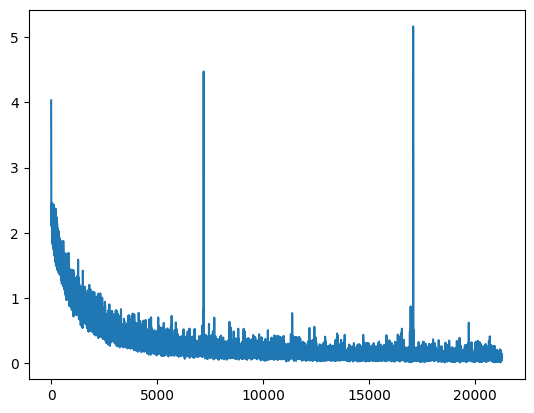

In [ ]:
import matplotlib.pyplot as plt
plt.plot(TP_losses)
plt.grid()
plt.show()

In [ ]:
TP_trainer.test(TP_t,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0:  13%|█▎        | 1338/10417 [03:28<23:37,  6.40it/s]
Testing: 271it [00:40,  6.72it/s]

In [ ]:
loaded_list = []

with open('TPlosses.pickle', 'wb') as file:
    pickle.dump(TP_losses, file)

# Caricamento della lista da un file
with open('TPlosses.pickle', 'rb') as file:
    loaded_list = pickle.load(file)

In [ ]:
sum(TP_acc)/len(TP_acc)

0.8369037445618397

In [22]:
import torch
import torch.nn as nn
import math
import pytorch_lightning as pl
import torch.optim as optim
import torch.nn.functional as F

class TPMultiHeadAttention(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, dropout=0.1):
        super(TPMultiHeadAttention, self).__init__()
        assert emb_dim % num_heads == 0, "emb_dim must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = self.emb_dim // num_heads

        # Inizializzazione dei moduli lineari per proiettare Q, K, V e l'output.
        self.W_q = nn.Linear(self.emb_dim, self.emb_dim*num_heads)
        self.W_k = nn.Linear(self.emb_dim, self.emb_dim*num_heads)
        self.W_v = nn.Linear(self.emb_dim, self.emb_dim*num_heads)
        self.W_r = nn.Linear(self.emb_dim, self.emb_dim*num_heads)
        self.W_o = nn.Linear(self.emb_dim, self.emb_dim)


    def forward(self, q,k,v,r, mask=False):
        q = self.split_heads(self.W_q(q))
        k = self.split_heads(self.W_k(k))
        v = self.split_heads(self.W_v(v))
        r = self.split_heads(self.W_r(r))

        att = self.att_score(q, k, v, mask)
        out = self.W_o(self.combine_heads(att*r))
        return out

    def att_score(self, q, k, v, mask):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)

        if mask: attn_scores=self.apply_mask(attn_scores)

        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, v)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.emb_dim).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, head_dim = x.size()
        return torch.sum(x, dim = 1)

    def apply_mask(self,tensor):
        mask = torch.triu(torch.full((tensor.shape[2], tensor.shape[3]), float("-inf"), device=device), diagonal=1)
        tensor = tensor + mask

        return tensor

class TPEncoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(TPEncoderLayer, self).__init__()

        self.multihead_attention = TPMultiHeadAttention(emb_dim, num_heads)

        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        att = self.multihead_attention(x,x,x,x)
        add_nor = self.layer_norm1(x + self.dropout(att))
        ff_out = self.feedforward(add_nor)
        out = self.layer_norm2(add_nor + self.dropout(ff_out))


        return out





class TPEncoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(TPEncoder, self).__init__()

        self.layers = nn.ModuleList([
            TPEncoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class TPDecoderLayer(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, feedforward_dim=32, dropout=0.1):
        super(TPDecoderLayer, self).__init__()

        # Self-Attention Layer (Auto-Attention)
        self.self_attention = TPMultiHeadAttention(emb_dim, num_heads)

        # Cross-Attention Layer (Attenzione incrociata con l'encoder)
        self.cross_attention = TPMultiHeadAttention(emb_dim, num_heads)

        # Feedforward Neural Network Layer
        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, emb_dim)
        )

        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(emb_dim)
        self.layer_norm2 = nn.LayerNorm(emb_dim)
        self.layer_norm3 = nn.LayerNorm(emb_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output):

        attn_output = self.self_attention(x, x, x, x, mask=True)
        out1 = self.layer_norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attention(out1, encoder_output,encoder_output, out1)
        out2 = self.layer_norm2(out1 + self.dropout(attn_output))
        ff_output = self.feedforward(out2)
        out3 = self.layer_norm3(out2 + self.dropout(ff_output))
        return out3

class TPDecoder(pl.LightningModule):
    def __init__(self, emb_dim, num_heads, num_layers=6, feedforward_dim=32, dropout=0.1):
        super(TPDecoder, self).__init__()


        self.layers = nn.ModuleList([
            TPDecoderLayer(emb_dim, num_heads, feedforward_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, encoder_output):
        for layer in self.layers:
            x = layer(x, encoder_output)
        return x



class TPTransformer(pl.LightningModule):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8, num_layers=6, d_ff=256, dropout=0.1, teacher_forcing_ratio = 0.9):
        super(TPTransformer, self).__init__()
        self.d_model=d_model

        self.num_heads=num_heads
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.tgt_vocab_size=tgt_vocab_size

        self.transformer_encoder = TPEncoder(self.d_model,self.num_heads)
        self.transformer_decoder = TPDecoder(self.d_model, self.num_heads)

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)


    def forward(self, batch):

        if self.training:
            teacher_force = random.random() < self.teacher_forcing_ratio
            if teacher_force:
                return self.classic_forward(batch)
            else:
                return self.predict(batch[0])
        return self.predict(batch)


    def classic_forward(self,batch):
        src,tgt = batch
        max_seq_length=src.shape[1]
        batch_size = src.shape[0]
        tgt = torch.cat((torch.ones((batch_size,1), dtype=torch.int).to(device), tgt[:, :-1]), dim = 1)

        src_embedded = self.dropout(self.src_embedding(src))+self.positional_encoding(max_seq_length,self.d_model).to(device)
        tgt_embedded = self.dropout(self.tgt_embedding(tgt))+self.positional_encoding(max_seq_length,self.d_model).to(device)

        enc_output = self.transformer_encoder(src_embedded)
        dec_output = self.transformer_decoder(tgt_embedded, enc_output)
        output = self.fc(dec_output)

        return output


    def training_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(batch)
        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        TP_losses.append(loss.cpu().detach().numpy())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch
        output = self(src, tgt)

        loss = nn.CrossEntropyLoss(ignore_index=0)(output.view(-1, output.size(-1)), tgt.view(-1))
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

    def test_step(self, batch, batch_idx):
        batch_q, batch_a = batch
        ans_len=batch_a.shape[1]

      # Computing prediction and accuracy
        pred = self(batch_q)  # shape (batch_size, answer_max_length, dict_size)
        accuracy = paper_accuracy(pred, batch_a)  # accuracy for the current batch as defined in the "mathematics dataset" paper

        #print(accuracy)  # at the end of every epoch it is logged the average of the accuracies of each batch
        TP_acc.append(accuracy)

        return accuracy



    def positional_encoding(self, max_seq_length, d_model):

        positional_encoding = torch.zeros(max_seq_length, d_model)
        pos = torch.arange(0, max_seq_length, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        positional_encoding[:, 0::2] = torch.sin(pos * div_term)
        positional_encoding[:, 1::2] = torch.cos(pos * div_term)
        return positional_encoding

    def predict(self, x):
        length=x.shape[1]
        src_embedded = self.src_embedding(x).to(device)+self.positional_encoding(length,self.d_model).to(device)
        encode = self.transformer_encoder(src_embedded)
        batch_dim = x.shape[0]
        out = torch.zeros((batch_dim, length), dtype = torch.int).to(device)
        out[:,0] = 1
        output=torch.zeros(batch_dim,length,self.tgt_vocab_size).to(device)
        for i in range(length - 2 ):
            tgt_embedded = self.tgt_embedding(out)+self.positional_encoding(length,self.d_model).to(device)
            decode = self.transformer_decoder(tgt_embedded, encode)
            output[:,i]+=self.fc(decode)[:,i]
            prob = F.softmax(output , dim = -1)
            arg_max = torch.argmax(prob, dim = -1)
            out[:, i+1] = arg_max[:,i]
        return self.classic_forward((x,out))


TP_acc=[]
TP_losses=[]
TP_voc_len=len(tokenizer.vocab)
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TP_t=TPTransformer(TP_voc_len,TP_voc_len, d_model = 128)
TP_t.to(device)
print(device)
# Addestra il modello

train_dataset = Dataset(qtp,atp)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
TP_trainer = pl.Trainer(max_epochs=5)  # Modifica il numero di epoche come desiderato
TP_trainer.fit(TP_t, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type      | Params
--------------------------------------------------
0 | src_embedding       | Embedding | 5.9 K 
1 | tgt_embedding       | Embedding | 5.9 K 
2 | transformer_encoder | TPEncoder | 3.3 M 
3 | transformer_decoder | TPDecoder | 6.6 M 
4 | fc                  | Linear    | 5.9 K 
5 | dropout             | Dropout   | 0     
--------------------------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.735    Total estimated model params size (MB

cuda


Training: 0it [00:00, ?it/s]

In [ ]:
i = 30000
q,a= train_dataset[i]
length = q.shape[0]
print(q.device)
print(TP_t.device)

TP_t.to(device)

pred = TP_t.predict(q.unsqueeze(0).to(device))
c = translate_from_output(pred.squeeze(0), tokenizer.vocab)
d = translate(a.squeeze(0), tokenizer.vocab)
print(pred)
print(translate(q,tokenizer.vocab))
print(translate(a,tokenizer.vocab))
print("trad 1: ", translate_from_output(pred.squeeze(0),tokenizer.vocab))
g = a

cpu
cpu
miaosaaaa
snarps
snarps
snarps
snarps
miaos
torch.Size([1, 8, 22, 512])


RuntimeError: shape '[1, 22, 512]' is invalid for input of size 90112